# Time series prediction with multimodal distributions - Neural Networks and Tensorflow Probability

The two most common neural network problems are regression and classification. One of the major differences between the two is that classification outputs the probability of a given class, while regression outputs the value of the predicted variable without any information about the uncertenity of the forecast. Even classification models outputs only numbers, not distributions, but most of the time this approach is satisfactory to estimate the uncertentiy of the prediction. 

To adress this problem we can use Monte Carlo Dropout, here you can find an example: https://www.depends-on-the-definition.com/model-uncertainty-in-deep-learning-with-monte-carlo-dropout/.
Monte Carlo Dropout can be a good choice in some cases, but I will show an example, where this technique won't really improve our forecast, because the tipical loss functions (mostly MSE) used in regression will always tend to center the output around the mean of the distribution, and can't capture multimodal phenomenons.

Recently I started to explore Tensorflow Probability https://www.tensorflow.org/probability, a library built on Tensorflow, which enables us to estimate the aleatoric uncertainty (known unknowns) and epistemic uncertainty (unknown unknowns) of our model and data. This article https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html gives a really good basic idea about the potential of this library to estimate model uncertainty, but Tensorflow Probability has much more use cases.

In this article I will focus on the estimation of the known unknowns. Using Tensorflow Probability I will build an LSTM based time-series forecaster model, which is able to predict uncertainty and capture multimodal patterns if it exists in the data.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from tensorflow import keras
import time

In [2]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
matplotlib 3.0.3
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [3]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## The Dataset

In [4]:
def generate_time_series(batch_size, n_in, n_out):
    """
    Generate a batch of time-series, where the target part is randomly
    goes up or down
    """
    t = np.arange(n_in + n_out)
    series = np.zeros((batch_size, n_in + n_out))
    series += 0.1 * (np.random.normal(0, 0.5, (batch_size, n_in + n_out)))
    series[:, -n_out:] += (np.arange(n_out)) * 0.05
    sign = (np.random.choice([-1, 1], batch_size, p=[0.35, 0.65])) # randomize the output part
    series[:, -n_out:] *= sign[..., np.newaxis]
    return series[..., np.newaxis].astype(np.float32)

In [5]:
# generate the time-series, train, valid and test set

np.random.seed(42)

n_in = 30 # the length of the input part
n_out = 10 # the length of the output (forecasted) part
series = generate_time_series(5000, n_in, n_out)
print(series.shape)
X_train, Y_train = series[:3000, :n_in], series[:3000, n_in:]
X_valid, Y_valid = series[3000:4000, :n_in], series[3000:4000, n_in:]
X_test, Y_test = series[4000:, :n_in], series[4000:, n_in:]
Y_train = np.squeeze(Y_train)
Y_valid = np.squeeze(Y_valid)
Y_test = np.squeeze(Y_test)

(5000, 40, 1)


In [6]:
X_train.shape, Y_train.shape

((3000, 30, 1), (3000, 10))

In [7]:
def plot_multiple_forecasts(X, Y, Y_pred=None, title=""):
    n_in = X.shape[1]
    n_out = Y.shape[1]
    fig= plt.figure(figsize=(10,6))
    plt.xlabel("$t$", fontsize=16)
    plt.ylabel("$x(t)$", fontsize=16)
    plt.title(title, fontsize=16)
    for i in range(20):
        plt.plot(X[i, :, 0])
        plt.plot(np.arange(n_in, n_in + n_out), Y[i, :], "x-")
        if(Y_pred is not None):
            plt.plot(np.arange(n_in, n_in + n_out), Y_pred[i, :], "+-", markersize=10)

In the chart below we can see the shape of our series. I wanted to use as simple data as possible to show some pitfalls of non-probabilistic models. Instead of a continous time-series I generated a batch of samples with the same patterns. With this data it is easier to show the behaviour of our forecast. The input data or X is a 30 steps series without any pattern or slope, it is only white noise. The target part or Y goes up with 65 percent chance and goes down with 35 percent chance, and has some noise as well. 

It is easy to recognize the bimodal nature of the target forecast steps in this series by humans, and it is noticeable that the up-trend is more common than the down-trend. If we would stick one sample to the end of the other and would make a common continous time-series it would be harder to recognize this bimodal nature of the series, and in case of real data we are rarely able to recognize similar patterns. With neural networks our input and output space can have multiple dimensions, wich makes it even harder or impossible to catch potential multinomial divergences.

Bimodal or multimodal patterns aren't so rare that we should neglect them all the time. Some example where this kind of pattern can occur:
- Financial time-series at regular economic news can go up and down based on the surprise of the incoming data. As far as we don't know the side of the surprise, the movement of the price will have bimodal distribution based on our knowledge.
- Peak traffic hours or restaurant hours, or lot of other things in our timetable.
- Daily average precipitation during the year in large part of the world.
These are obvious examples, not hard to show on a histogram, but neural networks can be able to find "latent" multimodality, because of their power in pattern recognition.

Among the examples above the first example deserves more regard. Our historical series obviously will be the same regardless of our input data. But the distribution of the forecast and the modality of the distribution will depend on our prior knowledge.

Here I make some assumption about the possible forecasted distributions to show how important can be our prior knowledge, and how it can alter our posterior distribution, but I have to stress that these are only my actual assumptions. I will examine it in an upcoming article if they really behave this way or not.
In our thought experience we use the USD/JPY pair, which in my experience is very sensitive to regular economical news outcomes. Let's distinguish three different priors:

- We know only the earlier movement of the price.
- We know the earlier movement of the price and the time of economic news.
- We know the earlier movement of the price, the time of economic news and the surprise factor.

In the first case we know nothing about the news. Our model see only the earlier price movement, and one step before the economic news will be blind to the possible up or down jump because of the surprise. This model will even if capable to forecast a multimodal distribution will probaly expect some more simmetric normal-like outcome.
In the second case our model knows the time of the news, but not its surprise factor. A model trained on this dataset will probably know one step before the news that a big jump can come, but not the diection of the jump. This model will most likely forecast a bimodal distribution, probably with peaks of different hights based on our price history. 
In the third case we know the time and the surprise of the news as well. Of course this isn't possible before the time of the news. This knowledge will most probably reduce one peak of our bimodal distribution, as the model knows the the historical effect of this side of the surprise, and most probably will forecast a more unimodal distribution.

These conclusions are traceable by humans, but a very high dimension dataset can hide connections or patterns from us, but not necessarily from a neural network.

Ok, let's go back to our basic example, to see how can we implement a model capable to forecast our peaks with Keras and Tensorflow Probability.

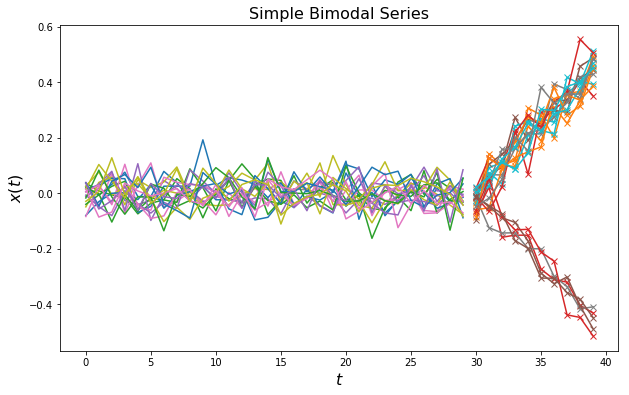

In [8]:
plot_multiple_forecasts(X_train, Y_train, Y_pred=None, title="Simple Bimodal Series")
plt.show()

## Forecasting with simple regression

To demontstrate the inability of the most common regression models to recognize bimodal paterns I build a simple LSTM model. The model complexity here doesn't matter. With a better model we can be able to predict more accuratelly the mean of the possible future paths, but in some datasets there is a chance, that the mean path will never happen. Unfortunatelly with non-probabilistic approaches we can't do better, and even Dropout Monte Carlo will fail.

In [9]:
def simple_conv_and_lstm_layout(window_size, targetsize):  
    """
    Define a simple LSTM layout
    """    
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=[window_size, 1]), 
        keras.layers.LSTM(20, return_sequences=False), # for simpler Y_valid tensor we don't use return_sequences=True here
        keras.layers.Dense(targetsize)
    ])
    return model

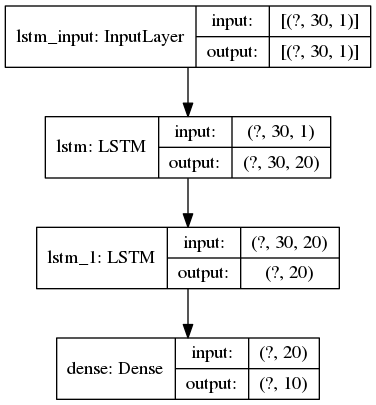

In [10]:
model_lstm_ts10 = simple_conv_and_lstm_layout(window_size=30, targetsize=10)
keras.utils.plot_model(model_lstm_ts10, "model_lstm_ts10.png", show_shapes=True)

In [11]:
# this pattern is very easy, 3 epochs is enough
optimizer = keras.optimizers.Adam(lr=0.001)
model_lstm_ts10.compile(loss="mse", optimizer=optimizer)
history = model_lstm_ts10.fit(X_train, Y_train, epochs=3,
                    validation_data=(X_valid, Y_valid))

Train on 3000 samples, validate on 1000 samples
Epoch 1/3
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.0682 - val_loss: 0.0657
Epoch 2/3
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.0673 - val_loss: 0.0655
Epoch 3/3
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.0673 - val_loss: 0.0655


In [12]:
model_lstm_ts10.evaluate(X_test, Y_test)

1000/1000 [==============================] - 0s 316us/sample - loss: 0.0634


0.06337230983376503

In the graph below we can see that the model did a preatty good job if our only concern is the mean squared error. The real paths are denoted by "x", and the forecast paths by the "+" sign. 65% of our paths go up, 35% go down, so the forecast is an up-trend between the two. This isn't a bad forecast, depending on the problem this can be the estimate what we really want. 

But if the data consists of the GPS coordinates of drones that reached our destination, and we want to send the next drone on the best possible path, then we definitelly should avoid these kind of predictions, as we can easily hit the tree between the roads. Maybe this isn't the best example, but it is obvious that in some cases the mean can be a very unprobable point, and we don't want very unprobable points to be our forecast.

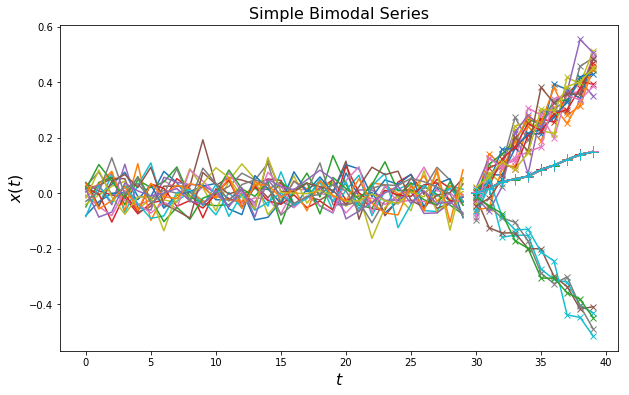

In [13]:
Y_pred = model_lstm_ts10.predict(X_test)
plot_multiple_forecasts(X_train, Y_train, Y_pred, title="Simple Bimodal Series")
plt.show()

## Fitting Unimodal Distribution to the data

Our artificial data has very similar distribution at every future steps. The added noise has the same variance, only the means of the peaks are further from zero. I will examine the 6th step (index=5), the other steps has similar properties.

First we fit a normal distribution to the 6th forecast step. In the graph below we can see that this distribution how badly represents our data. As we fitted this distribution to the data itself, this is the best guess we can hope from a unimodal normal.

In [14]:
# build normal distribution fitted to the 6th forecast step
nd_test = tfd.Normal(loc=np.mean(Y_test[:,5]), scale=np.std(Y_test[:,5]))

In [15]:
# check the statistics of the 6th forecast step
print(np.mean(Y_test[:,5]))
print(np.std(Y_test[:,5]))

0.09380316
0.23473465


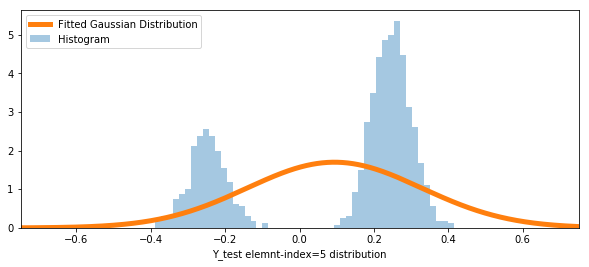

In [16]:
lower = -0.75
upper = 0.75

f = plt.figure(figsize=(10,4))
ax = plt.gca()
sns.distplot(Y_test[:,5], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")

ax.set_xlabel("Y_test elemnt-index=5 distribution")
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, nd_test.prob(x).numpy(), lw=5, label="Fitted Gaussian Distribution")
_ = ax.legend()

## Fitting Bimodal Distribution to the data

Instead of a unimodal Gaussian we can try to fit a bimodal Gaussian. Our artificial data is well separated, it isn't hard to build a distribution model close to the real one. 

In [17]:
# separate the positive and negative branches
Y_test_neg_5 = Y_test[:, 5][Y_test[:, 5] < 0]
Y_test_pos_5 = Y_test[:, 5][Y_test[:, 5] >= 0]

In [18]:
print(np.mean(Y_test_neg_5))
print(np.mean(Y_test_pos_5))
print(np.std(Y_test_neg_5))
print(np.std(Y_test_pos_5))
print(Y_test_neg_5.shape[0])
print(Y_test_pos_5.shape[0])

-0.24779344
0.2472741
0.051770695
0.05170076
310
690


We estimate the weights of the distributions from the occurence of the negative or positive paths, and calculate the means and standard deviations of the positive and negative samples. With the MixtureSameFamily class it is very easy to build the mixture distribution that well fits our data, and it would be awesome if we could forecast that distribution with a neural network.

As you have foreseen we can do that :) These networks are called Mixture Density Networks, and here you can read an awesome article about the math behind them. https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca
(I borrowed the style of the histogram graphs as well, thanks Olover Borchers https://towardsdatascience.com/@oliverbor)
In the article above you can check how to implement a mixture density layer yourself. Here I will use the MixtureNormal layer https://www.tensorflow.org/probability/api_docs/python/tfp/layers/MixtureNormal from the tensorflow probability library.


In [19]:
# rebuild the distribution from the data
weights = [Y_test_neg_5.shape[0], Y_test_pos_5.shape[0]]
means = [np.mean(Y_test_neg_5), np.mean(Y_test_pos_5)]
sigmas = [np.std(Y_test_neg_5), np.std(Y_test_pos_5)]

gm_test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.Normal(
        loc=means,       
        scale=sigmas))

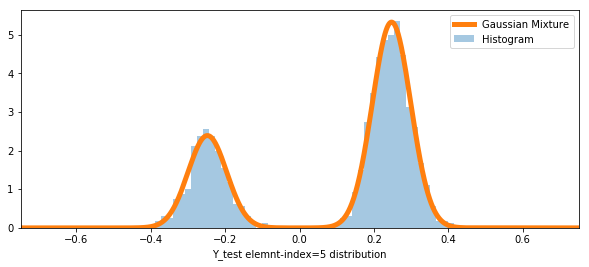

In [20]:
f = plt.figure(figsize=(10,4))
ax = plt.gca()
sns.distplot(Y_test[:,5], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")

ax.set_xlabel("Y_test elemnt-index=5 distribution")
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, gm_test.prob(x).numpy(), lw=5, label="Gaussian Mixture")
_ = ax.legend()

## The Mixture Density Network

This mixture density network will use the MixtureNormal layer, but the other parts of the network are very similar to the non-probabilistic network we used earlier. There are two main differences. Instead of the Dense layer we use a MixtureNormal layer. The LSTM layer before the MixtureNormal layer has the proper size of neurons to satisfy the needs of the MixtureNormal, and I set the activation to "None", because the constraints of the default "tanh" are too restrictive to the MixtureNormal parameters.

With real datasets we don't know how many peaks our distributions can have, and the number of submodels can change depending on the input and the forecast step. Pretending that weI don't know the number of peaks we set the number of component distributions to 3. 

The parameter size for the MixturNormal layer can be calculated easily. We have (3 components) * (10 steps) * (2 parameters of the Normal distributions) + 3 weight of the components = 63, but it is safer to calculate it in the following way.

(In this model the weights of the components doesn't change from one forecast step to the other, but it is possible to make weights with more dimensions. Here with our 3 components and 10 forecast step we could have a (3, 10) shaped tensor as our component weight.)

In [21]:
# define the output distribution parameters
num_components = 3   # Number of components in the mixture (2 would be optional, but most of the time we don't know)
event_shape = [10]   # shape of the target (10 steps)
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)   # calculate the required input size for the mixture layer
print(params_size)

63


In [22]:
# network layout with mixtureNormal layer

inputs = keras.layers.Input(shape=(30, 1))
h1 = keras.layers.LSTM(20, return_sequences=True)(inputs)
h2 = keras.layers.LSTM(params_size, return_sequences=False, activation=None)(h1) # !!! params_size
dl = tfp.layers.MixtureNormal(num_components, event_shape)(h2)

model_mx = keras.models.Model(inputs=[inputs], outputs=[dl])

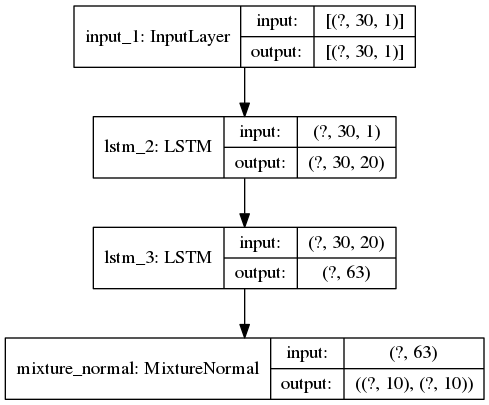

In [23]:
keras.utils.plot_model(model_mx, "model_mx.png", show_shapes=True)

We can estimate how probable is our data given our distribution. Log probabilities are more practical for computations. Negative log probabilites give us the loss functions we want to minimize. This loss function is very simple to implement when the output of our model is a tensorflow distribution object.

In [24]:
# loss function for distributions
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [25]:
# Let's Rock and Roll!
optimizer = keras.optimizers.Adam(lr=0.001)
model_mx.compile(loss=negloglik, optimizer=optimizer)
history = model_mx.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 13s 4ms/sample - loss: 3.5784 - val_loss: 1.4438
Epoch 2/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 5.5227 - val_loss: 5.9679
Epoch 3/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 5.9470 - val_loss: 5.9049
Epoch 4/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 5.8647 - val_loss: 5.7957
Epoch 5/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 5.7044 - val_loss: 5.5498
Epoch 6/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 4.9370 - val_loss: 2.6014
Epoch 7/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -2.0586 - val_loss: 5.4593
Epoch 8/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 5.1094 - val_loss: 4.0225
Epoch 9/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -6.8036 - val_loss: -11.7338
Epoch 10/20

In our dataset every case is very similar to the other, the difference is only the noise, so we will examine only the first example from the test set.

In [26]:
# Our inputs are very similar, so we use only the first element to forecast our distribution
yhat = model_mx(X_test[:1,:,:])
assert isinstance(yhat, tfd.Distribution)

Our distribution consist of different submodules. The parameters of these submodules are our forecasted variables.

In [27]:
# the components of our mixture model
yhat.submodules

(<tfp.distributions.Independent 'model_mixture_normal_MixtureSameFamily_independent_normal_IndependentNormal_Independentmodel_mixture_normal_MixtureSameFamily_independent_normal_IndependentNormal_Normal' batch_shape=[1, 3] event_shape=[10] dtype=float32>,
 <tfp.distributions.Categorical 'model_mixture_normal_MixtureSameFamily_Categorical' batch_shape=[1] event_shape=[] dtype=int32>,
 <tfp.distributions.Normal 'model_mixture_normal_MixtureSameFamily_independent_normal_IndependentNormal_Normal' batch_shape=[1, 3, 10] event_shape=[] dtype=float32>)

One submodule describes the (3, 10) normal distributions we fitted to our data. We will check the 6th steps as earlier. We can see that the first two means are very close to our real means, and the third is close to zero.

In [28]:
# the Normal component mean for the 6th step
yhat_means = yhat.submodules[2].mean().numpy()
print(yhat_means.shape)
print(yhat_means[:,:,5])

(1, 3, 10)
[[-0.26222986  0.24365899  0.01705011]]


An other submodule - the Categorical distribution submodel - containes the weights of the components [0.29453883 0.6899422  0.01551905]. The first two weights are close to our 35% and 65%, and the third is practically negligable. The model was able to recognize that we have only two real components.

In [29]:
# the categorical component weights, with our model this is the same for all step,
# but could have the same dimension as the Normal mean
yhat_cw = yhat.submodules[1].probs_parameter().numpy()
print(yhat_cw.shape)
print(yhat_cw)

(1, 3)
[[0.29453883 0.6899422  0.01551905]]


In the graph below the line-widths are determined by the component weights. As we expected the upper trend is more frequent, but the lower trend is apparent as well, the third component is almost invisible.

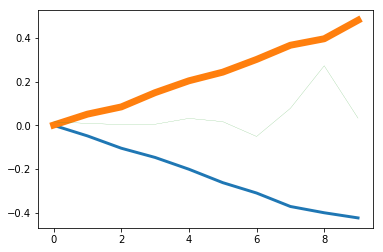

In [30]:
# the forecasted mean weighted by the weight of the corresponding distribution
plt.plot(yhat_means[0,0,:], linewidth=yhat_cw[0,0]*10)
plt.plot(yhat_means[0,1,:], linewidth=yhat_cw[0,1]*10)
plt.plot(yhat_means[0,2,:], linewidth=yhat_cw[0,2]*10)

The components with larger weights have small standard deviations, but the third component is relativelly large. Along with its small weight this further confirm that our third component is redundant. If we face such a component we should consider to drop it, or retrain our model with less components.

In [31]:
# the standard deviations of the 6th step
yhat_stddev = yhat.submodules[2].stddev().numpy()
yhat_stddev[:,:,5]

array([[0.04764858, 0.04561024, 0.5772563 ]], dtype=float32)

Next we will rebuild the forecasted distribution of the 6th step and compare it to the real distribution of the test set. The forecasted distribution fits well the data. Tunning the model probably could result an even better fit.

In [32]:
# rebuild the distribution of the 6th step from the forecasted data
gm_test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=yhat_cw[0]),
    components_distribution=tfd.Normal(
        loc=yhat_means[0,:,5],       
        scale=yhat_stddev[0,:,5]))

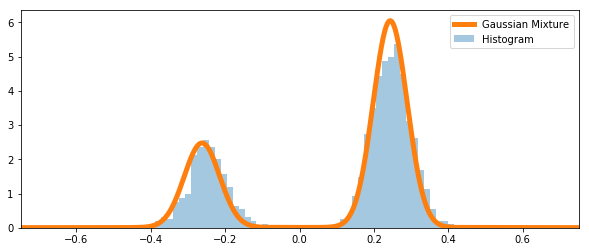

In [33]:
f = plt.figure(figsize=(10,4))
ax = plt.gca()
sns.distplot(Y_test[:,5], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, gm_test.prob(x).numpy(), lw=5, label="Gaussian Mixture")
_ = ax.legend()

## Probabilistic forecast visualization 

With non-probabilistic neural networks we get only one number for a variable. With probabilistic models we can get as many random forecast scenarios as we want, we can examine the mean of the distribution which is comparable to the non-probabilistic result, and we can examine the submodul means of a multinomial case. This can be seen in the figure below. We didn't drop our underweighted submodule, and because of that we got some very random forecast paths.

In [103]:
# sample from the forecasted distribution
smpl = yhat.sample(100).numpy()
smpl.shape

(100, 1, 10)

In [104]:
# distribution mean forecast
d_mean = np.squeeze(yhat.mean().numpy())

In [105]:
# submodel means
yhat_means = yhat.submodules[2].mean().numpy()

# submodel weights
yhat_cw = yhat.submodules[1].probs_parameter().numpy()

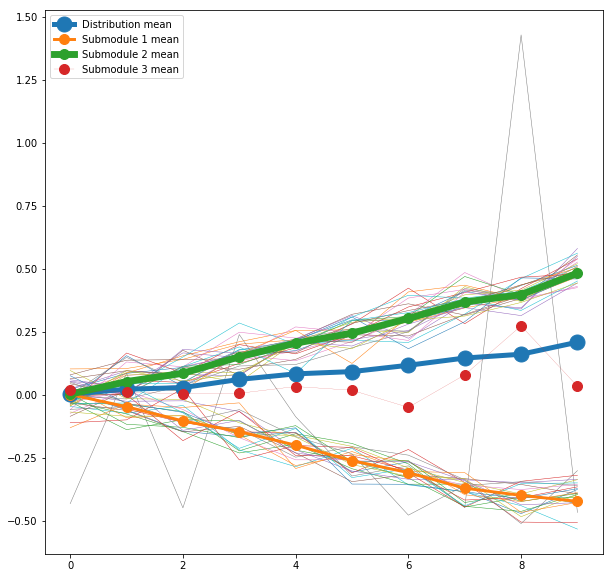

In [108]:
# the forecasted sample
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
for i in range(50):    
    ax.plot(smpl[i,0,:], linewidth=0.5)  
ax.plot(d_mean, linewidth=5, marker="o", ms=15, label="Distribution mean")
ax.plot(yhat_means[0,0,:], linewidth=yhat_cw[0,0]*10, marker="o", ms=10, label="Submodule 1 mean")
ax.plot(yhat_means[0,1,:], linewidth=yhat_cw[0,1]*10, marker="o", ms=10, label="Submodule 2 mean")
ax.plot(yhat_means[0,2,:], linewidth=yhat_cw[0,2]*10, marker="o", ms=10, label="Submodule 3 mean")
_ = ax.legend()

## End of the prologue

Here we saw the power of probabilistic neural networks. If other ideas will not seduce me, I will examine the earlier mentioned financial time-series. In an upcoming article, or articles I will use mixture density networks to build a more complex model to forecast multi dimensional financial time series. Instead of LSTM layers I plan to build a wavenet model, or some other CNN based architexture. According to my current idea the data will consist of different USD pairs and economic news times, but not the economic indicators. My focus will be the effect of economic news, and the occurence of distribution peaks far from each other. I plan to find trading opportunities, where according to the model trading a forex pair is safe. Where the forecasted distributions of the relative price movements has small overlaps for the forecasted period, the currencies are safe to trade against each other. I don't plan to use very large datasets, and from that small dataset I don't hope real life forecast power. I only plan to build some teqhniques which can be used with models of better forecast power.

Thanks for reading. If you have any remark, critic or idea you want to share write in the comments or send a message on Linkedin. https://www.linkedin.com/in/istvanveber/